In [9]:
import os
import sys
from datetime import datetime 
from datetime import timedelta
import cv2
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook

In [10]:
# Set-up directory

disk_name = 'FRED SHONE' # Memory Stick
disk_location = '/Volumes'
disk_path = os.path.join(disk_location, disk_name)
print(disk_path)

/Volumes/FRED SHONE


In [11]:
# Access daily sub-directories of images

folders = sorted(os.listdir(disk_path)) # Assumes sorting by name is ok - but this won't work for changes in year

# Filter for days by trying to convert to datetime

day_directories = []
for folder in folders:
    try: 
        datetime.strptime(folder, '%m-%d-%Y')
        day_directories.append(folder)
    except: pass
    
print(day_directories)

['01-03-2015', '01-04-2015']


In [12]:
# Check for number of images in day directories

for day_directory in day_directories:
    day_dir_path = os.path.join(disk_path, day_directory)
    image_paths = os.listdir(day_dir_path)
    image_paths = sorted([image for image in os.listdir(day_dir_path) if not image.startswith('.')])
    image_count = len(image_paths)
    print('{}: {} images'.format(day_directory, image_count))   
    #Wilkins building listed as opening hours from 8am to 11pm = 15 hours
    frame_rate = image_count/(15*60*60)
    print('frame rate assumed to be ~{} frames per second'.format(frame_rate))

01-03-2015: 16684 images
frame rate assumed to be ~0.30896296296296294 frames per second
01-04-2015: 16680 images
frame rate assumed to be ~0.3088888888888889 frames per second


In [13]:
# Set-up motion detector
trigger = 0.0001 # Total pixel difference to trigger motion detection
warning_trigger = 10000 # Total pixel difference to trigger verbose image plot
trigger_record = [] # Record of triggers
verbose = False 
start_time = '08:00' # Assumes camera turned on at 8am every day
frame_step = 3 # Seconds


In [15]:
for day_directory in tqdm_notebook(day_directories, desc='Days:'):
    '''
    print('------------------------------')
    print('>>> Processing images for {}'.format(day_directory))
    '''
    day_dir_path = os.path.join(disk_path, day_directory)
    images = sorted([image for image in os.listdir(day_dir_path) if not image.startswith('.')])
    
    date = datetime.strptime(day_directory,'%m-%d-%Y')
    start_datetime = datetime.strptime(day_directory+' '+start_time,'%m-%d-%Y %H:%M')
    
    background = None # Initialise with no background
    
    num_images = len(images) # Get amount of images for progress bar
        
    for image in tqdm_notebook(images, desc='{} progress:'.format(date)):
        
        image_path = os.path.join(day_dir_path, image)
        img = cv2.imread(image_path)
        
        # Reduce image size to 1%
        thumb = cv2.resize(img, None, fx=.1, fy=.1, interpolation = cv2.INTER_AREA)
        thumb = cv2.cvtColor(thumb, cv2.COLOR_BGR2GRAY)

        if background is None: # Initialise background for first pass
            background = thumb
            
        delta = cv2.absdiff(background, thumb)
        thresh = cv2.threshold(delta, 25, 255, cv2.THRESH_BINARY)[1]
        pixel_diff = cv2.sumElems(thresh)[0] # Need to check that this is the absolute difference
        
        if pixel_diff > img.size*trigger:
            
            # Extract frame number from imaga path
            image_index = [int(s) for s in list(image) if s.isdigit()]
            image_index = ''.join(str(x) for x in image_index) 
            image_index = int(image_index)
            
            # Calculate time stamp of frame
            time_delta = timedelta(seconds=(frame_step*image_index))
            time_stamp = start_datetime + time_delta
            
            if verbose:
                '''
                print('---------------')
                print(image) 
                print('Movement detected at {} with pixel delta of {}:'.format(str(time_stamp), pixel_diff))
                '''
                
                if pixel_diff < warning_trigger:
                    f, axarr = plt.subplots(1,3, figsize=(15,5))
                    axarr[0].imshow(background)
                    axarr[1].imshow(thresh)
                    axarr[2].imshow(thumb)
                    plt.show()

            
            trigger_record.append(time_stamp) # Add to record
        '''    
        i = int(100*index/(num_images-1))
        sys.stdout.write('\r')
        sys.stdout.write('Movement detected at {} with pixel delta of {}:'.format(str(time_stamp), pixel_diff))
        sys.stdout.write("[%-100s] %d%%" % ('='*i, i))
        sys.stdout.flush()
        '''
        background = thumb # Set background for next frame        

HBox(children=(IntProgress(value=0, description='Days:', max=2), HTML(value='')))

HBox(children=(IntProgress(value=0, description='2015-01-03 00:00:00 progress:', max=16684), HTML(value='')))

HBox(children=(IntProgress(value=0, description='2015-01-04 00:00:00 progress:', max=16680), HTML(value='')))

In [16]:
len(trigger_record)

13680

In [18]:
import pickle

In [32]:
time = datetime.now()
string = 'md_dump_'+time.strftime("%Y-%m-%d_%H-%M-%S")+'.dat'
string

'md_dump_2018-06-21_13-12-48.dat'

In [33]:
with open(string, "wb") as f:
    pickle.dump(trigger_record, f)

In [34]:
with open(string, 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    data = pickle.load(f)

In [37]:
len(data)

13680

In [64]:
import pandas as pd

In [207]:
motion_detections = pd.DataFrame({'timestamp':trigger_record})

In [257]:
start_time = min(motion_detections.timestamp).replace(hour=0, minute=0, second=0).to_pydatetime()
end_time = max(motion_detections.timestamp).replace(hour=0, minute=0, second=0).to_pydatetime() + timedelta(days=1)

In [259]:
time_range = pd.date_range(start=start_time, end=end_time, freq='H')
time_range_counter = pd.DataFrame({'timestamps':all_range, 'counter':0}).set_index('timestamps')

In [260]:
for detection in motion_detections.timestamp:
    detection_time = detection.replace(minute=0, second=0)
    time_range_counter.counter[detection_time] += 1

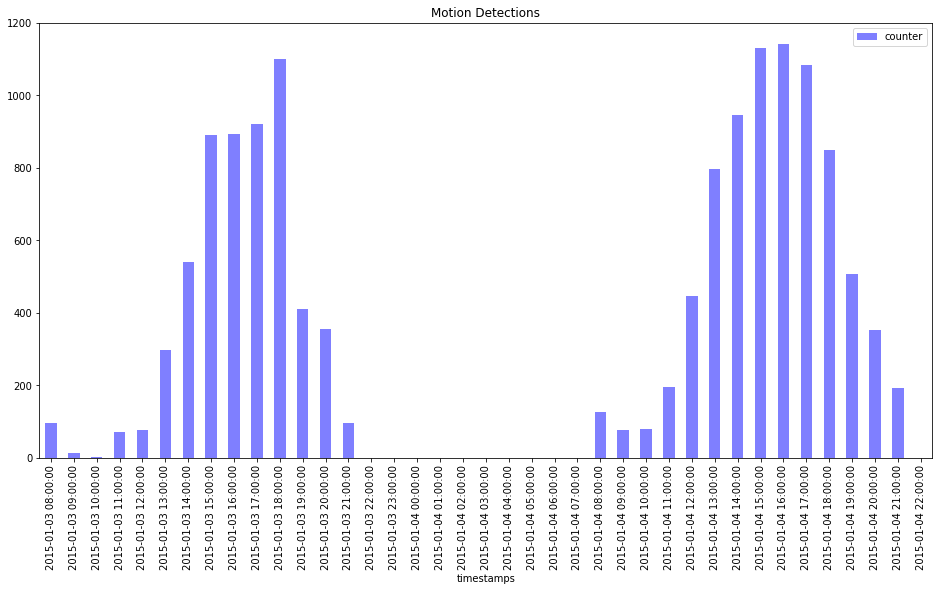

In [261]:
my_colors = 'b'
time_range_counter.plot(kind='bar',
             color=my_colors,
             alpha=0.5,
             figsize=(16,8),
             title='Motion Detections')


In [268]:
hour_motion_detections = motion_detections.groupby(motion_detections.timestamp.dt.hour).count()

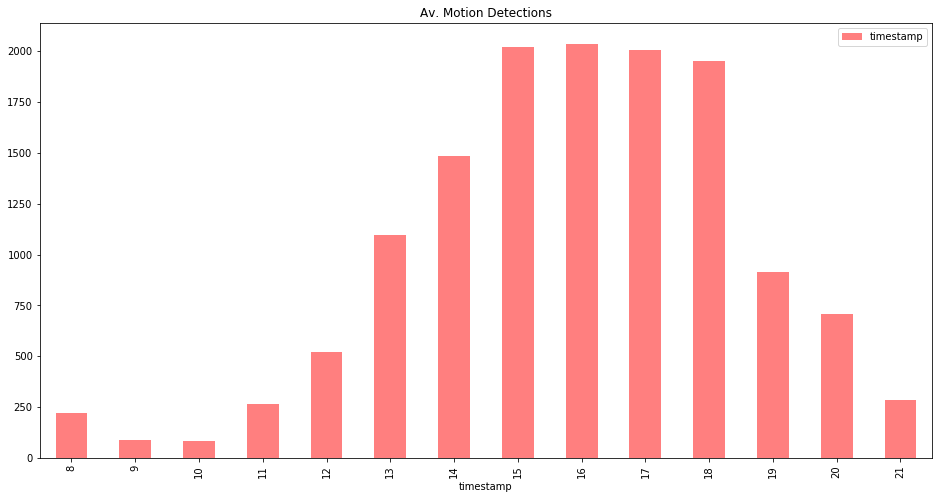

In [246]:
my_colors = 'r'
hour_motion_detections.plot(kind='bar',
             color=my_colors,
             alpha=0.5,
             figsize=(16,8),
             title='Av. Motion Detections')